#Data preprocessing

In [ ]:
!pip install click

In [ ]:
# This script takes the output file created in seurat and process
# it to be taken by Cibersortx to create signature matrix
# The file generated by this script has cell type per column
# and raw count for gene in the intersection of a cell type and a
# gene.
import click # pip install click

# Dictionary
dict_sequence_label = {}
# Key = cell sequence ; value : cell label

# Opening file with the conversion between sequence and cell label
# Column 1 : Single-Cell Barcode; Column 2 : Label (CD4, B, CD8 etc...)
input_directory = click.prompt('> Enter absolute path of input files directory')
output_directory = click.prompt('> Enter absolute path of output directory')

with open(input_directory+"Convert_UMI_Label.tsv","r") as file_cell_label:
    next(file_cell_label)
    #useless first line
    for line in file_cell_label:
        clean_line = line.rstrip("\n").split("\t")
        sequence = clean_line[0].replace("-","-") #Store barcode
        cell_label = clean_line[1] # Store Cell Label
        dict_sequence_label[sequence] = cell_label

print("dictionnary done !")

header = []
# Now i got the conversion between sequence and cell type
# i'll read the file with gene count per cell sequence
# and write a new file with the dictionnary above
with open(input_directory+"Gene_Count_per_Cell.tsv","r") as file_gene_count:
    first_line_cell_sequence = file_gene_count.readline()
    #The first line of export in R present a mistake
    #i save it and correct after
    #next(file_gene_count) #Delete first line
    with open(output_directory+"preSigMatrix.tsv","w") as file_matrix:
        split_first_line_cell_sequence = first_line_cell_sequence.rstrip("\n").split("\t")
        for element in split_first_line_cell_sequence:
            header.append(dict_sequence_label[element])
        file_matrix.write("GENES\t"+'\t'.join(header)+"\n")
        # Once I wrote all the cells label I can write the gene counts
        for line in file_gene_count:
            file_matrix.write(line)
# The script in finished and the file is now created.

print("Single Cell Raw Counts Annotated Matrix susccessfully created!")

> Enter absolute path of input files directory: /content/drive/MyDrive/Input MIT_ROSMAP/
> Enter absolute path of output directory: /content/drive/MyDrive/Input MIT_ROSMAP/
dictionnary done !
Single Cell Raw Counts Annotated Matrix susccessfully created!


#DNN Project

In [1]:
#### Step 1: Load data ####
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
path_data = '/content/drive/MyDrive/Input MIT_ROSMAP/'

Mounted at /content/drive


In [2]:
GeoMx = pd.read_csv(path_data + 'CAA_Q3Norm_TargetCountMatrix Vascular ROIs for MC-CAA database.txt',
                                             sep='\t', index_col=0, header=0)#['TargetName'].values.flatten()  # name of the GeoMx genes
GeoMx_genes = GeoMx.index
gene_list = []
for gene in GeoMx_genes:
    gene_list.append(gene)   # "(GENE0, GENE1, ...)"

GeoMxT = GeoMx.T

CAA_TargetROI = pd.read_csv(path_data + 'GeoMx_individual_human-CAA Labels.csv',
                                             sep=',', index_col=0, header=0)


CAA_TargetROI = CAA_TargetROI.LabelCAA

#CAA Data base to work as a validation
MC_CAA = pd.read_csv(path_data + "MC-CAA_Geneexpression_FPKM_OnlyGeoMx genes.csv",
                                             sep=',', index_col=0, header=0)

MC_CAAT = MC_CAA.T
MC_CAATarget = pd.read_csv(path_data + "MC-CAA_individual_human-CAA Labels.csv",
                                              sep=',', index_col=0, header=0)
MC_CAATarget = MC_CAATarget.LabelCAA        #Labels for the MC CAA, anything with presence of CAA = 0, else = 1



#scMIT_ROSMAPVasc = pd.read_csv(path_data+"preSigMatrix.tsv", sep="\t", index_col=0, header=0)

#scMIT_ROSMAPVasc = scMIT_ROSMAPVasc[scMIT_ROSMAPVasc.index.isin(GeoMx_genes)]

In [43]:
#Divide data Train/Test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(GeoMxT, CAA_TargetROI, test_size=0.3, random_state=72)


# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

#scale MC-CAA data
#t.fit(MC_CAAT)
MC_CAATT = t.transform(MC_CAAT) #Transposed (T) & Transformed (T) data

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
#Autoencoder
# number of input genes
n_inputs = GeoMxT.shape[1]
lvl1ae =  1000
lvl2ae =  lvl1ae/2
lvl3ae =  lvl2ae/2
lvl4ae = lvl3ae/2
lvl5ae = lvl4ae/2
#print(GeoMxT.shape[1])
# define encoder
inputlayer = Input(shape=(n_inputs,))
# encoder level 1
ae = Dense(lvl1ae, activation='tanh', name='enc1')(inputlayer)
#
ae = BatchNormalization()(ae)
#ae = LeakyReLU()(ae)
# encoder level 2
ae = Dense(lvl2ae, activation='tanh', name='enc2')(ae)
#activation='tanh',
ae = BatchNormalization()(ae)
#ae = LeakyReLU()(ae)
# encoder level 3
ae = Dense(lvl3ae, activation='tanh', name='enc3')(ae)
#activation='tanh',
ae = BatchNormalization()(ae)
#ae = LeakyReLU()(ae)
# encoder level 4
ae = Dense(lvl4ae, activation='tanh', name='enc4')(ae)
#activation='tanh',
ae = BatchNormalization()(ae)
#ae = LeakyReLU()(ae)
# encoder level 5
ae = Dense(lvl5ae, activation='tanh', name='enc5')(ae)
# activation='tanh'
ae = BatchNormalization()(ae)
#ae = LeakyReLU()(ae)

# bottleneck
n_bottleneck = round(float(lvl5ae) / 2.0)
bottleneck = Dense(n_bottleneck)(ae)

# define decoder, level 1
d = Dense(lvl5ae, activation='tanh', name='dec1')(bottleneck)
d = BatchNormalization()(d)
#d = LeakyReLU()(d)
# define decoder, level 2
d = Dense(lvl4ae, activation='tanh', name='dec2')(bottleneck)
d = BatchNormalization()(d)
#d = LeakyReLU()(d)
# decoder level 3
d = Dense(lvl3ae, activation='tanh', name='dec3')(d)
d = BatchNormalization()(d)
#d = LeakyReLU()(d)
# decoder level 4
d = Dense(lvl2ae, activation='tanh', name='dec4')(d)
d = BatchNormalization()(d)
#d = LeakyReLU()(d)
# decoder level 5
d = Dense(lvl1ae, activation='tanh', name='dec5')(d)
d = BatchNormalization()(d)
#d = LeakyReLU()(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=inputlayer, outputs=output)

# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
#plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18617)]           0         
                                                                 
 enc1 (Dense)                (None, 1000)              18618000  
                                                                 
 batch_normalization (Batch  (None, 1000)              4000      
 Normalization)                                                  
                                                                 
 enc2 (Dense)                (None, 500)               500500    
                                                                 
 batch_normalization_1 (Bat  (None, 500)               2000      
 chNormalization)                                                
                                                                 
 enc3 (Dense)                (None, 250)               125250

In [ ]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=128, verbose=2, validation_data=(X_test,X_test))

Epoch 1/200
1/1 - 19s - loss: 0.3471 - val_loss: 0.3827 - 19s/epoch - 19s/step
Epoch 2/200
1/1 - 0s - loss: 0.3061 - val_loss: 0.3754 - 47ms/epoch - 47ms/step
Epoch 3/200
1/1 - 0s - loss: 0.2604 - val_loss: 0.3740 - 47ms/epoch - 47ms/step
Epoch 4/200
1/1 - 0s - loss: 0.2420 - val_loss: 0.3732 - 45ms/epoch - 45ms/step
Epoch 5/200
1/1 - 0s - loss: 0.2325 - val_loss: 0.3715 - 45ms/epoch - 45ms/step
Epoch 6/200
1/1 - 0s - loss: 0.2188 - val_loss: 0.3694 - 47ms/epoch - 47ms/step
Epoch 7/200
1/1 - 0s - loss: 0.2086 - val_loss: 0.3671 - 46ms/epoch - 46ms/step
Epoch 8/200
1/1 - 0s - loss: 0.2021 - val_loss: 0.3646 - 49ms/epoch - 49ms/step
Epoch 9/200
1/1 - 0s - loss: 0.1967 - val_loss: 0.3628 - 46ms/epoch - 46ms/step
Epoch 10/200
1/1 - 0s - loss: 0.1911 - val_loss: 0.3612 - 52ms/epoch - 52ms/step
Epoch 11/200
1/1 - 0s - loss: 0.1860 - val_loss: 0.3593 - 47ms/epoch - 47ms/step
Epoch 12/200
1/1 - 0s - loss: 0.1820 - val_loss: 0.3571 - 53ms/epoch - 53ms/step
Epoch 13/200
1/1 - 0s - loss: 0.1782 -

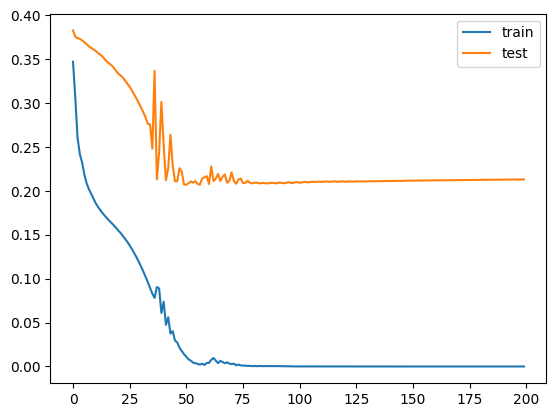

In [ ]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
#Define an encoder model (without the decoder)
encoder = Model(inputs=inputlayer, outputs=bottleneck)
plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
#save the encoder to file
encoder.save('CAA_encoder.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# evaluate logistic regression on encoded input
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

# load the model from file
CAA_encoder = load_model(path_data+'CAA_encoder.h5')
# encode the train data
X_train_encode = CAA_encoder.predict(X_train)
# encode the test data
X_test_encode = CAA_encoder.predict(X_test)

1/1 [==============================] - 0s 26ms/step


In [11]:
X_train_encode.shape

(20, 31)

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=n_bottleneck))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-06), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               8192      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)               

In [7]:
# fit the model on the training set
history = model.fit(X_train_encode, y_train, epochs=1000, batch_size=8, verbose=2, validation_data=(X_test_encode,y_test))

Epoch 1/1000


ValueError: ignored

In [ ]:
# make predictions on the test set
yhat = model.predict(X_test_encode)
# calculate classification accuracy
print("Real---- ")
print(y_test)
print("Predicted----")
print(yhat)

1/1 [==============================] - 0s 69ms/step
Real---- 
TargetName
2736_023_VasFree       1
2736_022_VasFree       1
2733_004_VasAmyloid    0
2733_007_VasAmyloid    0
2733_018_VasFree       1
2736_008_VasAmyloid    0
2733_003_VasAmyloid    0
2733_005_VasAmyloid    0
2733_020_VasFree       1
Name: LabelCAA, dtype: int64
Predicted----
[[0.5371341 ]
 [0.5318018 ]
 [0.5303511 ]
 [0.5310964 ]
 [0.53454083]
 [0.53715724]
 [0.5274963 ]
 [0.5267054 ]
 [0.53393924]]


In [27]:
#Feed forward DNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras import regularizers
# specify the input size of input dimensions
InputDNN = Input(shape=(n_bottleneck,))
# encoder level 1
hid = Dense(n_bottleneck, activation='relu', name='Hidden1')(InputDNN)
#kernel_regularizer=regularizers.L1L2(l1=0.05, l2=0.02)
hid = BatchNormalization()(hid)
# a drop out layer for regularization (25% probability)
hid = Dropout(0.23)(hid)
# first fully-connected layer to map the features to vectors of size encoded input
hid = Dense(250, activation='relu',kernel_regularizer=regularizers.L1L2(l1=0.185, l2=0.15), name='Hidden2')(hid)
#hid = BatchNormalization()(hid)
# second fully-connected layer to map the features to vectors of size half of encoded input
hid = Dense(250, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.25, l2=0.07), name='Hidden3')(hid)
#hid = BatchNormalization()(hid)
hid = Dropout(0.23)(hid)
# Third fully-connected layer to map the features to vectors of size quarter of encoded input
hid = Dense(100, activation='relu',  kernel_regularizer=regularizers.L1L2(l1=0.5, l2=0.1), name='Hidden4')(hid)
#hid = BatchNormalization()(hid)
# a drop out layer for regularization (25% probability)
#hid = Dropout(0.2)(hid)
#Fourth Layer size 10
hid = Dense(10, activation='relu',  kernel_regularizer=regularizers.L1L2(l1=0.2, l2=0.04), name='Hidden5')(hid)
#hid = BatchNormalization()(hid)
#Outputlayer Layer size 1
predictions = Dense(1, activation='sigmoid', name='Output')(hid)

# create the model using the layers we defined previously
DNN = Model(inputs=InputDNN, outputs=predictions)

# compile the model so that it uses Adam for optimization during training with cross-entropy loss
#optimizer = keras.optimizers.Adam(learning_rate=0.0001)
DNN.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-05), loss='mse', metrics=["acc"])

# print out a summary of the model achitecture
print(DNN.summary())


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 31)]              0         
                                                                 
 Hidden1 (Dense)             (None, 31)                992       
                                                                 
 batch_normalization_14 (Ba  (None, 31)                124       
 tchNormalization)                                               
                                                                 
 dropout_8 (Dropout)         (None, 31)                0         
                                                                 
 Hidden2 (Dense)             (None, 250)               8000      
                                                                 
 Hidden3 (Dense)             (None, 250)               62750     
                                                           

In [28]:
# fit the model on the training set
history = DNN.fit(X_train_encode, y_train, epochs=300, batch_size=60, verbose=2, validation_data=(X_test_encode,y_test))

Epoch 1/300
1/1 - 2s - loss: 1840.3383 - acc: 0.3500 - val_loss: 1840.0161 - val_acc: 0.6667 - 2s/epoch - 2s/step
Epoch 2/300
1/1 - 0s - loss: 1840.0066 - acc: 0.5000 - val_loss: 1839.7087 - val_acc: 0.6667 - 33ms/epoch - 33ms/step
Epoch 3/300
1/1 - 0s - loss: 1839.7366 - acc: 0.3500 - val_loss: 1839.4015 - val_acc: 0.6667 - 31ms/epoch - 31ms/step
Epoch 4/300
1/1 - 0s - loss: 1839.4368 - acc: 0.2000 - val_loss: 1839.0944 - val_acc: 0.6667 - 30ms/epoch - 30ms/step
Epoch 5/300
1/1 - 0s - loss: 1839.1013 - acc: 0.4000 - val_loss: 1838.7866 - val_acc: 0.6667 - 31ms/epoch - 31ms/step
Epoch 6/300
1/1 - 0s - loss: 1838.7961 - acc: 0.5000 - val_loss: 1838.4796 - val_acc: 0.6667 - 32ms/epoch - 32ms/step
Epoch 7/300
1/1 - 0s - loss: 1838.4957 - acc: 0.5000 - val_loss: 1838.1725 - val_acc: 0.6667 - 31ms/epoch - 31ms/step
Epoch 8/300
1/1 - 0s - loss: 1838.2035 - acc: 0.2000 - val_loss: 1837.8650 - val_acc: 0.6667 - 34ms/epoch - 34ms/step
Epoch 9/300
1/1 - 0s - loss: 1837.8578 - acc: 0.6000 - val_l

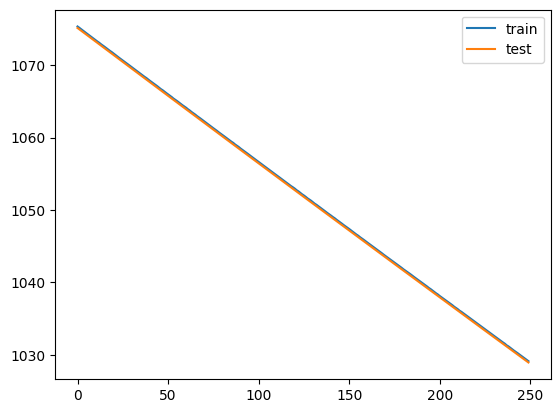

In [22]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [29]:
# make predictions on the test set
yhat = DNN.predict(X_test_encode)
# calculate classification accuracy
print("Real---- ")
print(y_test)
print("Predicted----")
print(yhat)

1/1 [==============================] - 0s 123ms/step
Real---- 
TargetName
2736_023_VasFree       1
2736_022_VasFree       1
2733_004_VasAmyloid    0
2733_007_VasAmyloid    0
2733_018_VasFree       1
2736_008_VasAmyloid    0
2733_003_VasAmyloid    0
2733_005_VasAmyloid    0
2733_020_VasFree       1
Name: LabelCAA, dtype: int64
Predicted----
[[0.53243953]
 [0.5041617 ]
 [0.4624147 ]
 [0.55799556]
 [0.525375  ]
 [0.4993182 ]
 [0.51283777]
 [0.48423332]
 [0.5519396 ]]


In [16]:
##MayoClinic Validation dataset MC-CAA
#Enconde MC-CAA dataset using the spatially resolved autoencoder
# load the model from file
CAA_encoder = load_model(path_data +'CAA_encoder.h5')
# encode the train data
MC_CAAE = CAA_encoder.predict(MC_CAATT)

3/3 [==============================] - 0s 5ms/step


In [17]:
DNN.metrics_names

['loss', 'acc']

In [44]:
DNN.evaluate(MC_CAAE, MC_CAATarget)

3/3 [==============================] - 0s 6ms/step - loss: 1749.3163 - acc: 0.5467


[1749.3162841796875, 0.54666668176651]

In [45]:
preds= DNN.predict(MC_CAAE)
# calculate classification accuracy
print("Real---- ")
print(MC_CAATarget)
print("Predicted----")
print(preds)

3/3 [==============================] - 0s 4ms/step
Real---- 
individualID
FH1      1
FH10     0
FH100    0
FH101    0
FH102    0
        ..
FH91     0
FH93     0
FH94     0
FH98     0
FH99     0
Name: LabelCAA, Length: 75, dtype: int64
Predicted----
[[0.4932239 ]
 [0.49054363]
 [0.49352226]
 [0.50463915]
 [0.49958816]
 [0.4967937 ]
 [0.4899391 ]
 [0.49581414]
 [0.49444467]
 [0.5006433 ]
 [0.50482994]
 [0.48927516]
 [0.49082175]
 [0.49997902]
 [0.50394225]
 [0.4901591 ]
 [0.49370396]
 [0.49572518]
 [0.48882452]
 [0.4901206 ]
 [0.490746  ]
 [0.48841718]
 [0.49466136]
 [0.49073327]
 [0.49157122]
 [0.49140927]
 [0.49162313]
 [0.49474737]
 [0.4934628 ]
 [0.49185184]
 [0.49623907]
 [0.48976508]
 [0.4910232 ]
 [0.49162602]
 [0.4947007 ]
 [0.4899358 ]
 [0.4914376 ]
 [0.49173802]
 [0.49478748]
 [0.49221414]
 [0.50632274]
 [0.5066995 ]
 [0.49212423]
 [0.5128977 ]
 [0.50413764]
 [0.48939636]
 [0.49940324]
 [0.49282992]
 [0.52001595]
 [0.5045007 ]
 [0.5057662 ]
 [0.51403886]
 [0.4912227 ]
 [0.4932

In [39]:
DNN.evaluate(X_train_encode, y_train)


1/1 [==============================] - 0s 27ms/step - loss: 1749.3145 - acc: 0.5500


[1749.314453125, 0.550000011920929]

[]

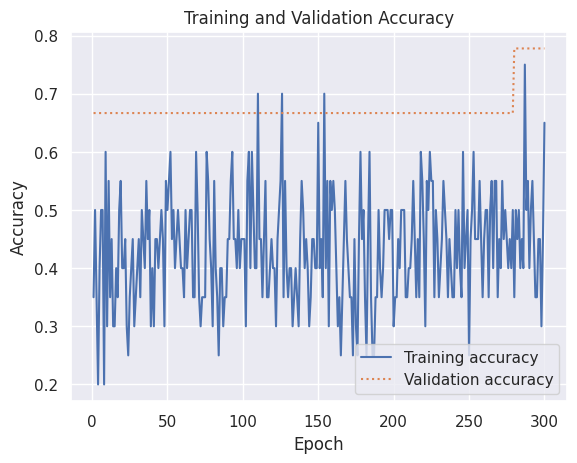

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = history.history['acc']
val = history.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

1/1 [==============================] - 0s 154ms/step


Text(109.44999999999997, 0.5, 'Actual label')

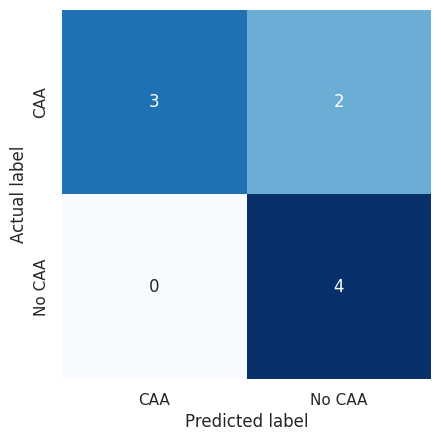

In [37]:
from sklearn.metrics import confusion_matrix
preds= DNN.predict(X_train_encode)

#y_predicted = preds > 0.5 #train
y_predicted = yhat > 0.5 #test
#mat = confusion_matrix(y_train, y_predicted)
mat = confusion_matrix(y_test, y_predicted)

labels = ['CAA', 'No CAA']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

3/3 [==============================] - 0s 3ms/step


Text(109.44999999999997, 0.5, 'Actual label')

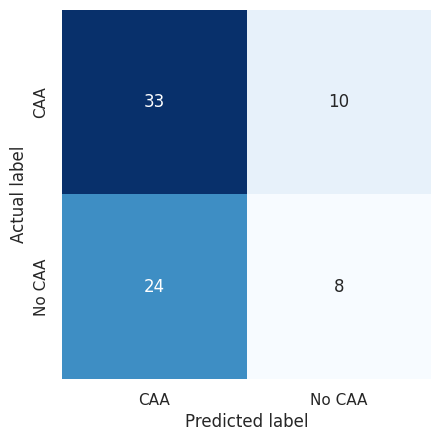

In [46]:
from sklearn.metrics import confusion_matrix
preds= DNN.predict(MC_CAAE)

y_predicted = preds > 0.5 #MC-validation

mat = confusion_matrix(MC_CAATarget, y_predicted)

labels = ['CAA', 'No CAA']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')